In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, backtest, v_backtester, c_backtester
import sys
from functools import partial
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 30
periods = 100
multi_periods = [25, 50, 75, 100]
multiplier = 20
bankroll = 15000
vol_lookback = 75
smooth = int(np.ceil(periods/4))
atr_periods = 80

In [3]:
contract = pd.read_pickle('data/minute_NQ_cont_non_active_included.pickle')
contract = contract.loc['20180202':]
#contract = contract.loc['20190401':]
#contract = contract.loc['20180202': '20180430']
#contract = contract.loc['20190101': '20190410']

In [4]:
contract

,open,high,low,close,volume,average,barCount
date,,,,,,,
2018-02-02 00:00:00,6954.00,6958.00,6953.50,6955.25,877,6955.025,362
2018-02-02 00:01:00,6955.25,6956.50,6952.50,6952.50,376,6955.150,201
2018-02-02 00:02:00,6952.50,6954.00,6951.25,6952.00,292,6952.525,141
2018-02-02 00:03:00,6951.75,6953.50,6951.00,6953.00,414,6952.250,140
2018-02-02 00:04:00,6952.75,6956.50,6952.75,6956.50,304,6954.275,123
...,...,...,...,...,...,...,...
2019-09-04 18:27:00,7695.50,7696.00,7694.75,7695.00,369,7695.475,178
2019-09-04 18:28:00,7695.00,7695.50,7694.75,7695.00,173,7695.025,72
2019-09-04 18:29:00,7695.00,7695.75,7694.50,7695.00,195,7695.125,87


In [5]:
vols = pd.DataFrame({'close': contract.close,})
vols['returns'] = vols['close'].pct_change()
vols['vol_returns'] = vols['returns'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
vols['vol_price'] = vols['vol_returns'] * vols['close']
vols['vol_price_alt'] = vols['close'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
vols.tail()

,close,returns,vol_returns,vol_price,vol_price_alt
date,,,,,
2019-09-04 18:27:00,7695.00,-0.000032,0.000206,1.588977,7.291065
2019-09-04 18:28:00,7695.00,0.000000,0.000204,1.567930,7.194505
2019-09-04 18:29:00,7695.00,0.000000,0.000201,1.547162,7.099224
2019-09-04 18:30:00,7697.50,0.000325,0.000205,1.579530,7.015990
2019-09-04 18:31:00,7697.25,-0.000032,0.000203,1.559378,6.931334


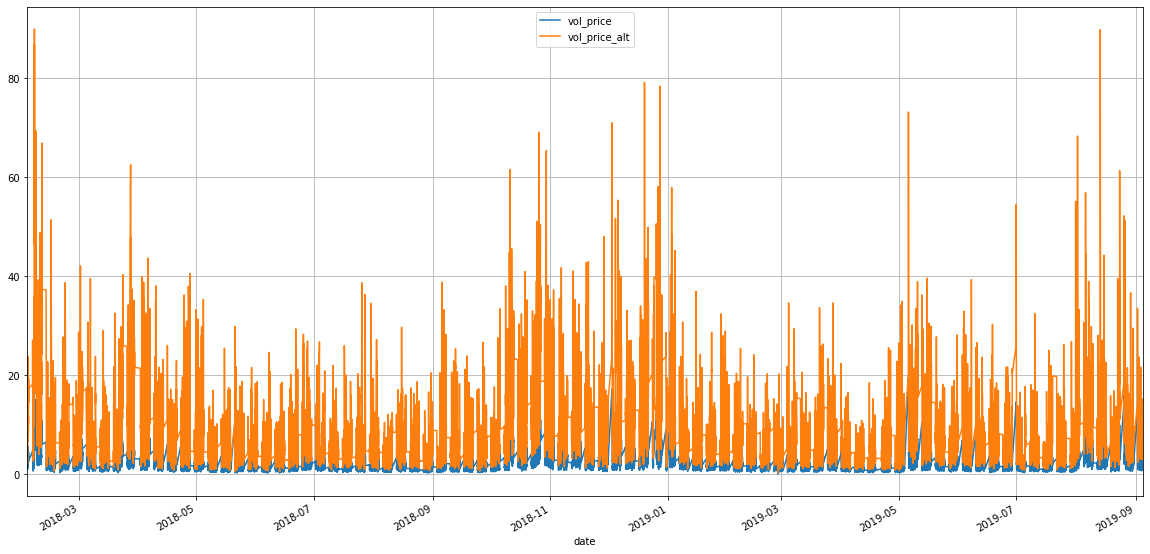

In [6]:
vols[['vol_price', 'vol_price_alt']].plot(figsize=(20,10), grid=True);

In [7]:
#avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

10116.65626191967

In [8]:
vol_candles = group_by_volume(contract, avg_vol)
vol_candles['atr'] = get_ATR(vol_candles, atr_periods)
vol_candles

,date,open,high,low,close,barCount,volume,atr
label,,,,,,,,
0,2018-02-02 01:49:00,6954.00,6963.50,6941.00,6941.75,5242,10045,22.500000
1,2018-02-02 03:59:00,6941.50,6946.25,6912.50,6939.00,5798,10297,28.195312
2,2018-02-02 08:10:00,6938.50,6944.00,6925.25,6934.50,5947,10143,24.967840
3,2018-02-02 10:02:00,6934.00,6935.25,6889.75,6892.00,5731,10153,30.294953
4,2018-02-02 11:01:00,6891.75,6897.75,6865.75,6867.50,5696,10293,30.653223
...,...,...,...,...,...,...,...,...
17402,2019-09-04 17:14:00,7678.50,7686.75,7678.25,7680.75,5355,10544,19.595184
17403,2019-09-04 17:31:00,7681.00,7696.00,7679.50,7696.00,5002,10577,19.518760
17404,2019-09-04 17:50:00,7696.00,7703.00,7695.50,7700.50,5423,11277,19.222000


In [9]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                     'close': vol_candles.close})

In [10]:
def carver(data, periods, smooth, *args):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'breakout_{periods}'] = data['breakout_norm'].ewm(span=smooth).mean()
    return data[f'breakout_{periods}']

In [11]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data['ema_diff_norm'] = data.ema_diff / vol
    #data['ema_diff_norm'] = data.ema_diff / data.ema_diff.rolling(periods).std()
    data[f'ema_{periods}'] = data['ema_diff_norm'].ewm(span=smooth).mean()
    return data[f'ema_{periods}']

In [12]:
def breakout(data, periods, smooth, *args):
    """
    this doesn't belong here
    """
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / data['breakout'].rolling(periods).std()
    data[f'breakout_{periods}'] = data['breakout_norm'].ewm(span=smooth).mean()
    return data[f'breakout_{periods}']

In [13]:
def vol(data, vol_lookback):
    data = data.copy()
    data['returns'] = data['close'].pct_change()
    data['vol_returns'] = data['returns'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
    data['vol_price'] = data['vol_returns'] * data['close']
    return data['vol_price']

In [14]:
vols = vol(data, vol_lookback)

In [15]:
def combine(data, multi_periods, smooth, vol, funcs):
    result = pd.DataFrame()
    for func in funcs:
        result[func.__name__] = pd.DataFrame([func(data, p, smooth, vol) for p in multi_periods]).T.mean(axis=1)
    return result

In [16]:
forecasts = combine(data, multi_periods, smooth, vols, [carver, ema])

In [17]:
forecasts

,carver,ema
label,,
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
17402,0.113546,0.568839
17403,0.123982,0.606511
17404,0.135138,0.646148


In [18]:
data = data.join(forecasts)
data = data.iloc[200:]

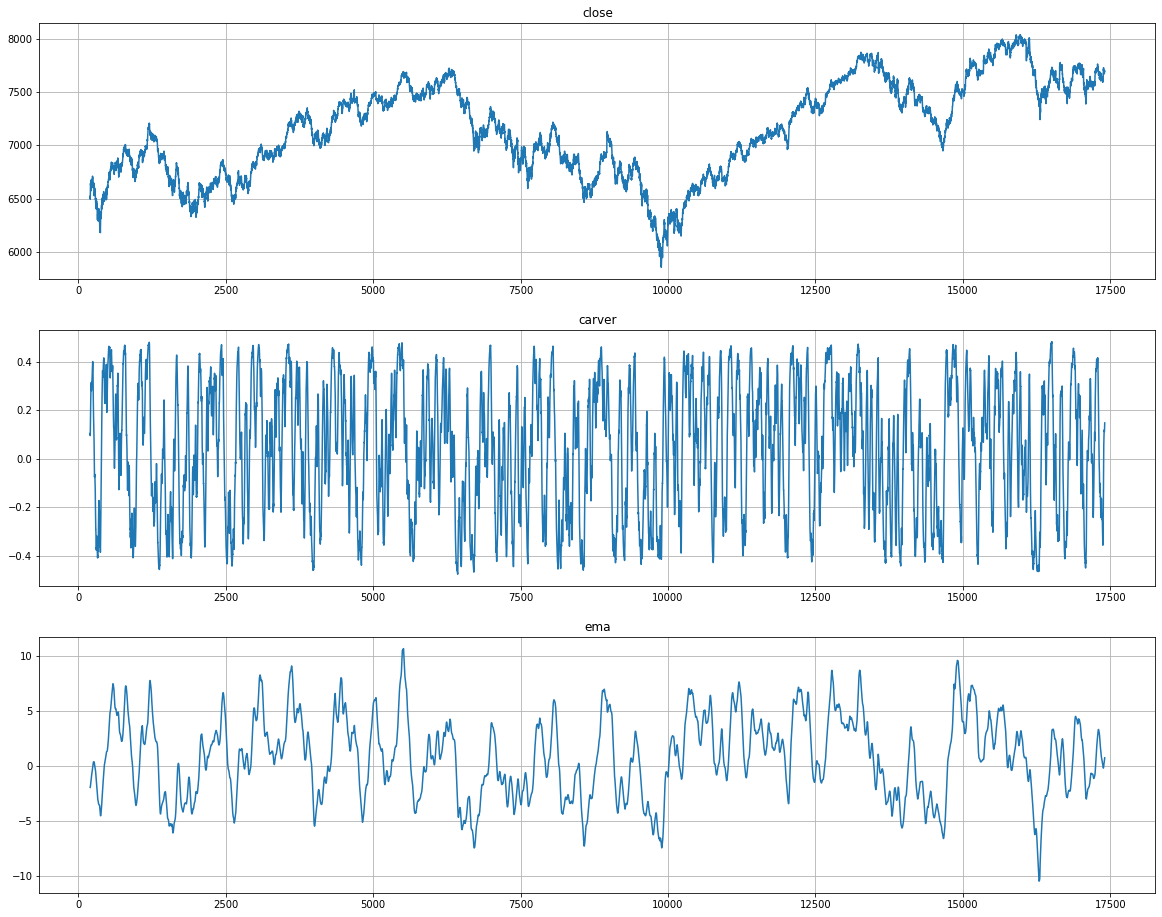

In [19]:
plot(data[['close', 'carver', 'ema']])

In [20]:
10 / data[['carver', 'ema']].abs().mean()

carver    43.922713
ema        3.226193
dtype: float64

In [21]:
scaled = pd.DataFrame({'date': data.date,
                       'open': data.open,
                       'close': data.close,
                       'carver': (data.carver * 43).clip(lower=-20, upper=20),
                       #'breakout': (data.breakout * 8.7).clip(lower=-20, upper=20),
                       'ema': (data.ema * 3.6).clip(lower=-20, upper=20)}
                     )

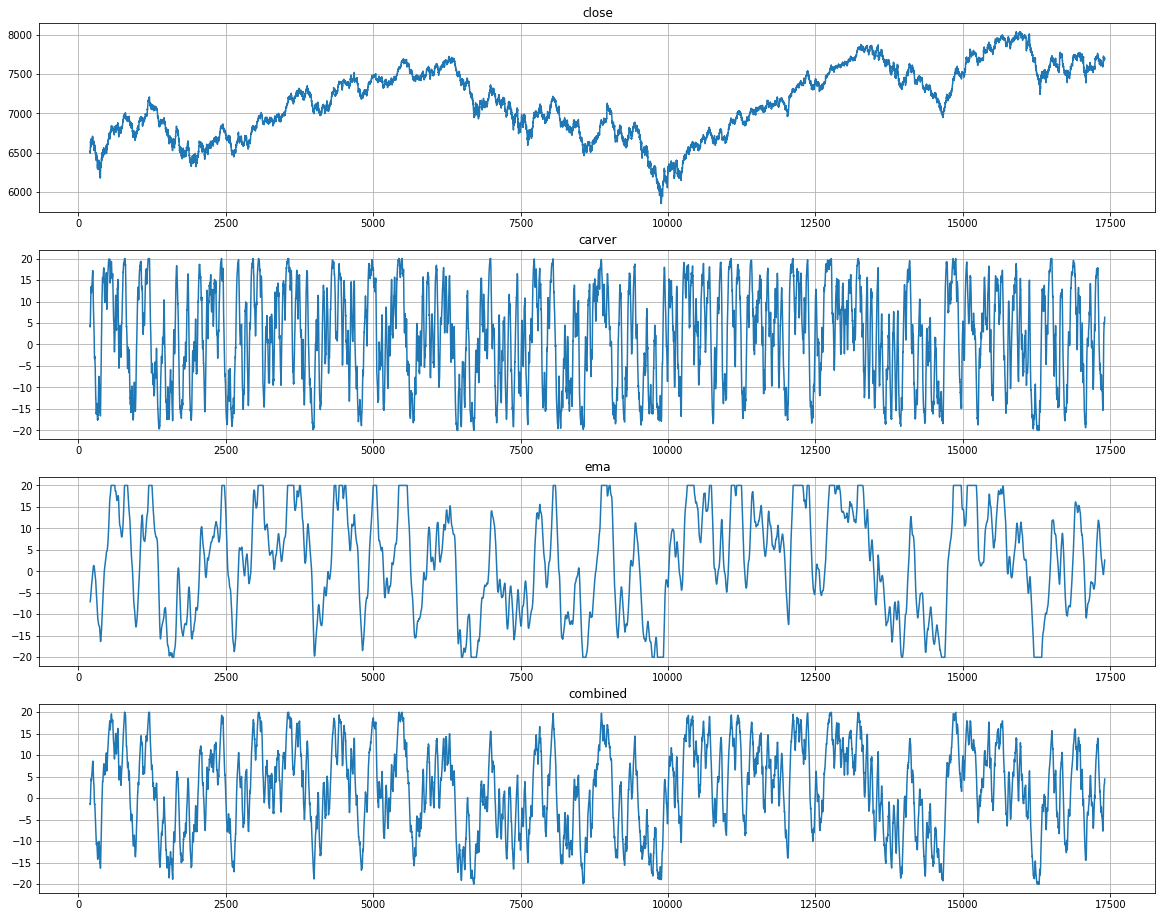

In [22]:
scaled['combined'] = scaled[['carver', 'ema',]].mean(axis=1)
plot(scaled[['close', 'carver', 'ema', 'combined']])

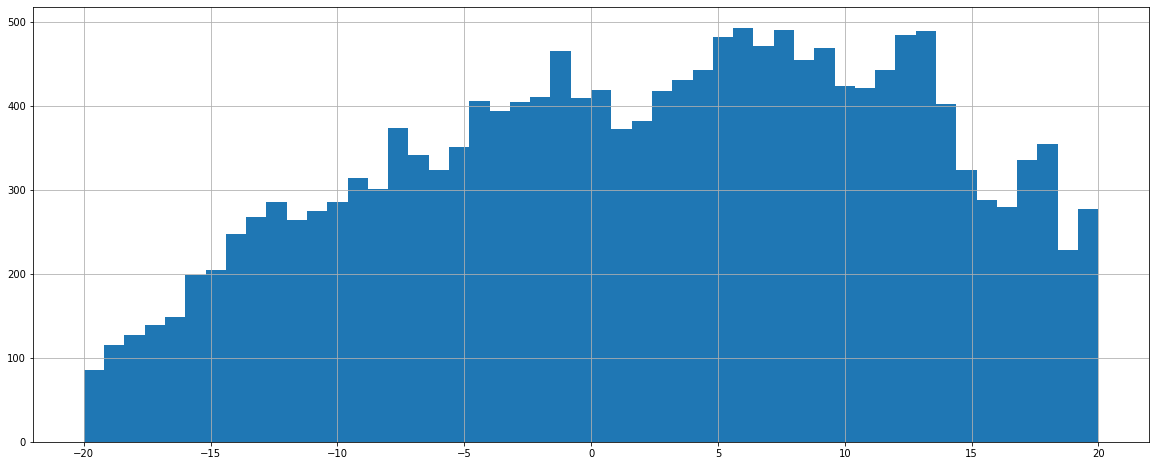

In [23]:
scaled['combined'].hist(figsize=(20,8), grid=True, bins=50);

In [24]:
scaled['combined'].std()

10.07426066980854

In [25]:
10 / scaled['combined'].std()

0.9926286729872802

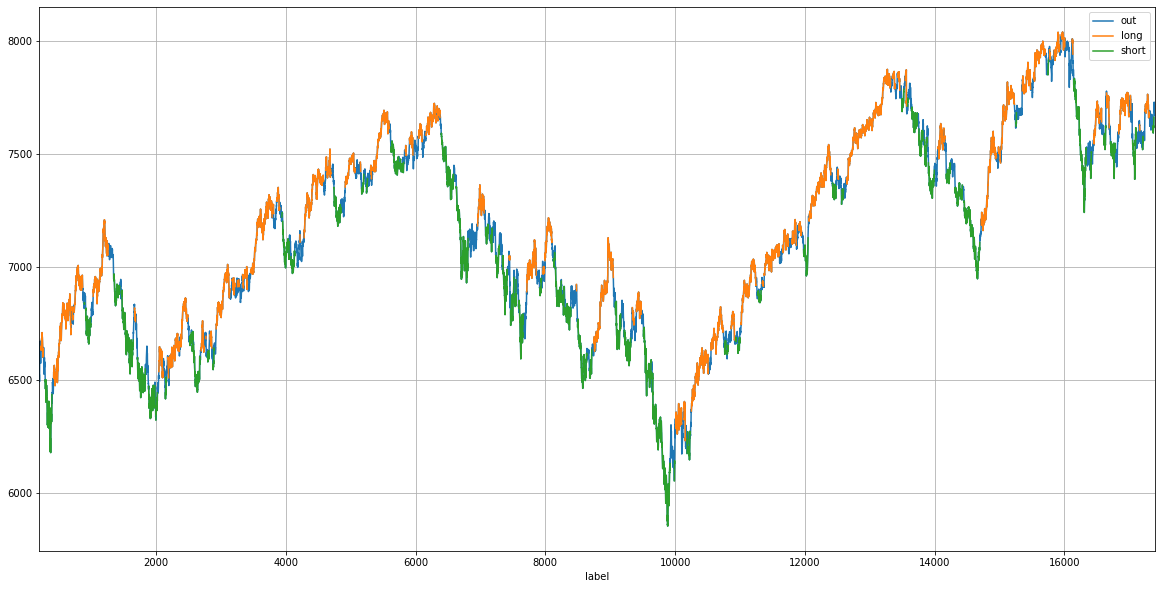

In [26]:
scaled_reindexed = scaled.set_index('date')
chart_price(scaled.close, scaled['combined'], 5)

Annual return                  0.606749
Cumulative returns              1.17533
Annual volatility              0.831014
Sharpe ratio                   0.974167
Calmar ratio                    1.60988
Stability                      0.695017
Max drawdown                  -0.376891
Omega ratio                     1.18856
Sortino ratio                   1.64596
Skew                           0.893977
Kurtosis                        2.65413
Tail ratio                      1.39349
Daily value at risk           -0.101485
Win percent                    0.345679
Average gain                    2198.48
Average loss                   -995.142
Avg gain/loss ratio             2.20922
Position EV                     108.827
Positions per day              0.392252
Days per position               2.54938
Actual avg. duration    2 days 12:09:00
Days                                413
Positions                           162
Trades                              324


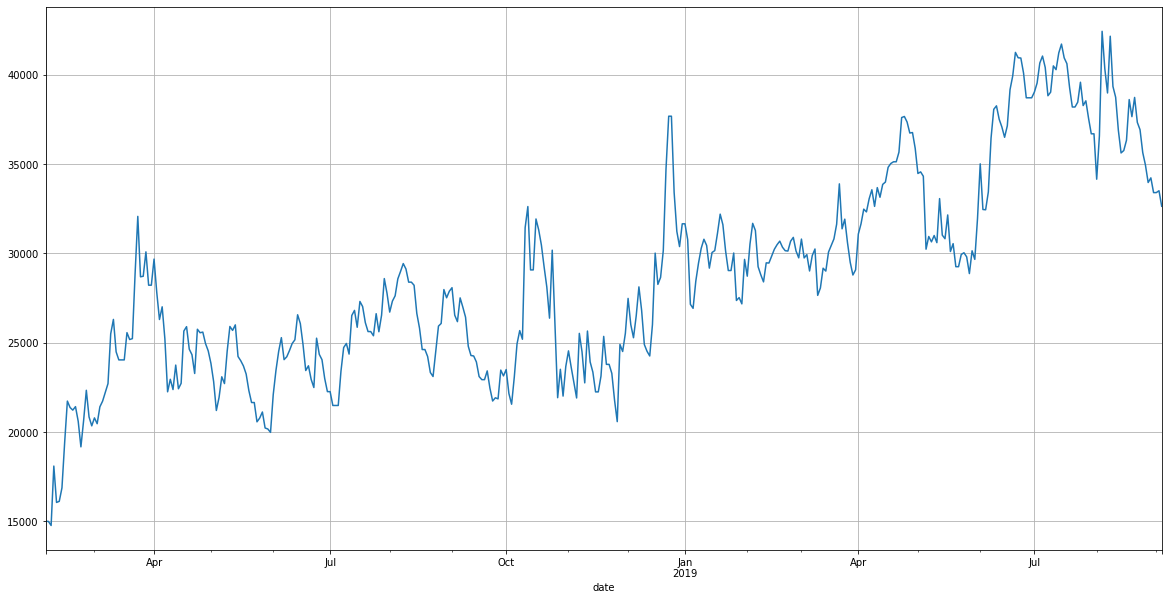

In [27]:
results = v_backtester(scaled_reindexed.open,
                   scaled_reindexed.combined, 
                   5, multiplier, bankroll)

In [28]:
stats = pd.DataFrame()
dailys = pd.DataFrame()
returns = pd.DataFrame()
for i in [0, 5, 10, 15]:
    r = v_backtester(scaled_reindexed.open,
                   scaled_reindexed.combined, 
                   i, multiplier, bankroll, False)
    stats[i] = r.stats
    dailys[i] = r.daily.balance
    returns[i] = r.daily['returns']

In [29]:
stats

,0,5,10,15
Annual return,0.517418,0.606749,0.18076,-0.2285
Cumulative returns,0.980667,1.17533,0.313,-0.346333
Annual volatility,1.40719,0.831014,1.03782,1.30607
Sharpe ratio,0.957422,0.974167,0.654181,0.36322
Calmar ratio,0.63207,1.60988,0.348932,-0.308065
Stability,0.118593,0.695017,0.183669,0.0893705
Max drawdown,-0.818609,-0.376891,-0.518037,-0.741726
Omega ratio,1.2036,1.18856,1.14799,1.12091
Sortino ratio,1.62714,1.64596,1.12735,0.713939
Skew,1.45493,0.893977,1.28946,3.79781


In [30]:
returns.corr()

,0,5,10,15
0,1.000000,0.803839,0.581942,0.341069
5,0.803839,1.000000,0.756594,0.450292
10,0.581942,0.756594,1.000000,0.620813
15,0.341069,0.450292,0.620813,1.000000


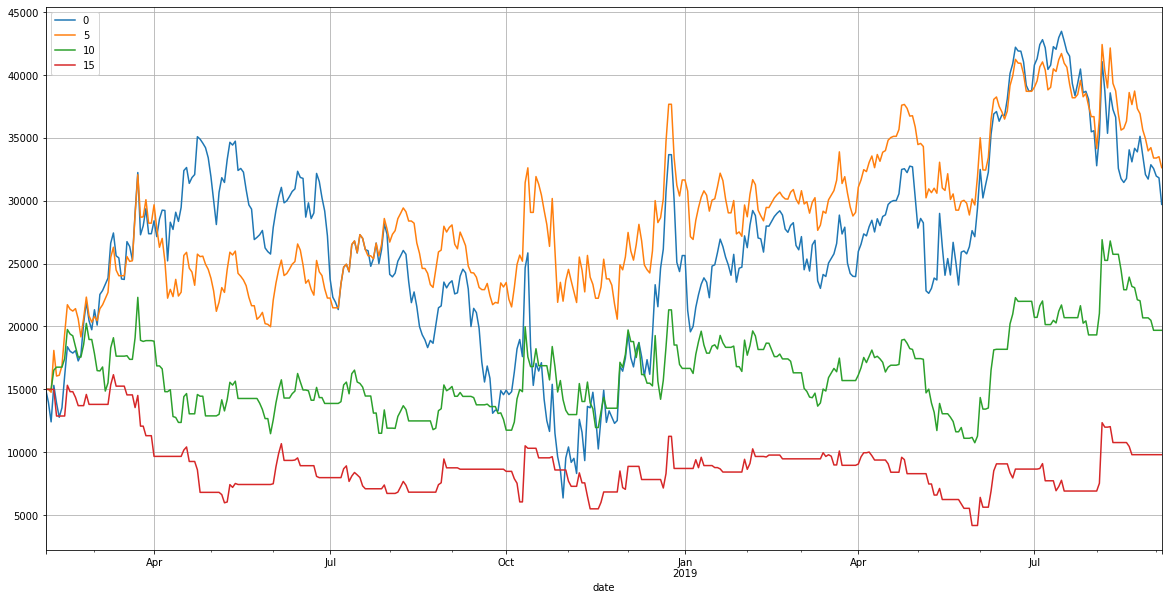

In [31]:
dailys.plot(figsize=(20,10), grid=True);

In [57]:
data = scaled_reindexed[['open', 'close',]]
data['indicator'] = scaled_reindexed['combined']
data['atr'] = vol_candles.set_index('date')['atr']

In [58]:
threshold = 5
commission = 0
sl_atr = 1
data['signal'] = ((data['indicator'] > threshold) * 1) + ((data['indicator'] < -threshold) * -1)
data['filtered_signal'] = data['signal']
data.reset_index(inplace=True)
data

,date,open,close,indicator,atr,signal,filtered_signal
0,2018-02-06 20:13:00,6515.50,6522.25,-1.297642,46.420182,0,0
1,2018-02-06 20:23:00,6522.50,6494.00,-1.454190,46.341401,0,0
2,2018-02-06 20:35:00,6494.25,6541.50,-1.251206,46.655925,0,0
3,2018-02-06 20:47:00,6542.25,6562.75,-0.888642,46.620998,0,0
4,2018-02-06 20:55:00,6562.25,6598.50,-0.330262,46.537265,0,0
...,...,...,...,...,...,...,...
17202,2019-09-04 17:14:00,7678.50,7680.75,3.465157,19.595184,0,0
17203,2019-09-04 17:31:00,7681.00,7696.00,3.757329,19.518760,0,0
17204,2019-09-04 17:50:00,7696.00,7700.50,4.068544,19.222000,0,0
17205,2019-09-04 18:15:00,7700.75,7697.75,4.280523,18.914049,0,0


In [34]:
# while in position maintain open price and transaction direction
data['positions'] = 0
# flag to execute transaction at next data point
data['mark'] = False
# note the reason for transaction at next data point
data['reason'] = ''
# record commission paid
data['commission'] = 0
# record transaction price
data['price'] = 0
# entry price for stop loss calculation
data['entry'] = 0
# for stop-loss calculation
data['high_water'] = 0
# whether stop loss is trailing or fixed
trailing_sl = False
# restrict re-entering positions after stop loss (1=long positions blocked, -1=short positions blocked)
block = 0

if trailing_sl:
    sl_field = 'high_water'
else:
    sl_field = 'entry'
    

for item in data.itertuples(): 
    # first row doesn't have to check if we have positions or execute transactions
    if not item.Index == 0:
        # starting position is the same as previous day position
        data.loc[item.Index, 'positions'] = data.loc[(item.Index - 1), 'positions'] 
        data.loc[item.Index, 'entry'] = data.loc[(item.Index - 1), 'entry'] 
        # execute transactions
        if data.loc[(item.Index -  1), 'mark']:
            # close position
            if data.loc[item.Index, 'positions']:
                data.loc[item.Index, 'positions'] = 0
                data.loc[item.Index, 'entry'] = 0
                # record transaction price
                data.loc[item.Index, 'price'] = item.open * np.sign(data.loc[(item.Index - 1), 'entry']) * -1
            # open position
            else:
                data.loc[item.Index, 'positions'] = data.loc[(item.Index - 1), 'signal']
                data.loc[item.Index, 'entry'] = item.open * data.loc[(item.Index - 1), 'signal']
                # record transaction price and high water mark
                data.loc[item.Index, 'price'] = item.open * data.loc[(item.Index -1), 'signal']
                data.loc[item.Index, 'high_water'] = data.loc[item.Index, 'price']
            # record commission paid
            data.loc[item.Index, 'commission'] = commission
            
    # update high water mark
    if not item.Index == 0: #skip first row
        if data.loc[item.Index-1, 'positions'] != 0:
            data.loc[item.Index, 'high_water'] = max(data.loc[item.Index - 1, 'high_water'], item.close*data.loc[item.Index, 'positions'])
   
    # check for close signal
    if data.loc[item.Index, 'positions'] != 0 and item.signal != data.loc[item.Index, 'positions']:
        data.loc[item.Index, 'mark'] = True
        data.loc[item.Index, 'reason'] = 'close'
    # check for stop-loss signal
    # long positions
    if data.loc[item.Index, 'positions'] > 0:
        if item.close <= (data.loc[item.Index, sl_field] - (item.atr * sl_atr)):
            data.loc[item.Index, 'mark'] = True
            data.loc[item.Index, 'reason'] = 'stop-out'
            block = 1
        
    # short positions
    if data.loc[item.Index, 'positions'] < 0:
        if item.close >= abs((data.loc[item.Index, sl_field] - (item.atr * sl_atr))):
            data.loc[item.Index, 'mark'] = True
            data.loc[item.Index, 'reason'] = 'stop-out'
            block = -1
        
    # check for entry signal
    if data.loc[item.Index, 'positions'] == 0:
        if item.filtered_signal != 0 and item.filtered_signal != block:
            data.loc[item.Index, 'mark'] = True
            data.loc[item.Index, 'reason'] = 'entry'
            block = 0
# close any open positions
if data[data.price != 0].price.count() % 2 != 0:
    data.loc[data.index[-1], 'price'] = data.open.iloc[-1] * np.sign(data.entry.iloc[-1]) * -1
    data.loc[data.index[-1], 'entry'] = 0
data.set_index('date', inplace=True, drop=True)

In [35]:
#data['mtm'] = (data['entry'] != 0) * (data['close'] - data['entry']) * data['positions']

In [36]:
data.iloc[50:].head(50)

,open,close,indicator,atr,signal,filtered_signal,positions,mark,reason,commission,price,entry,high_water
date,,,,,,,,,,,,,
2018-02-07 19:01:00,6647.75,6641.25,7.422819,33.089922,1,1,1,False,,0,0.00,6645.25,6710.50
2018-02-07 19:06:00,6640.75,6611.75,6.831897,33.062961,1,1,1,True,stop-out,0,0.00,6645.25,6710.50
2018-02-07 19:13:00,6611.25,6602.25,6.190781,32.789312,1,1,0,False,,0,-6611.25,0.00,6710.50
2018-02-07 19:19:00,6602.50,6628.00,5.816301,33.109889,1,1,0,False,,0,0.00,0.00,0.00
2018-02-07 19:28:00,6628.00,6608.00,5.270597,33.119537,1,1,0,False,,0,0.00,0.00,0.00
2018-02-07 19:39:00,6608.25,6639.00,5.064515,33.419553,1,1,0,False,,0,0.00,0.00,0.00
2018-02-07 19:49:00,6638.75,6633.75,4.821018,33.062937,0,0,0,False,,0,0.00,0.00,0.00
2018-02-07 20:03:00,6633.75,6619.00,4.449503,33.005737,0,0,0,False,,0,0.00,0.00,0.00
2018-02-07 20:18:00,6618.75,6633.75,4.244145,32.851036,0,0,0,False,,0,0.00,0.00,0.00


In [37]:
pnl = data[['open','positions', 'commission', 'mark', 'reason', 'price', 'entry']]
pnl['mark'] = pnl['mark'].shift(1)
pnl['reason'] = pnl['reason'].shift(1)

In [38]:
pnl = pnl[pnl.price != 0]
pnl['close'] = pnl.price.shift(-1)
pnl = pnl[pnl.reason == 'entry']
pnl['pnl'] = -(pnl.entry + pnl.close) * multiplier
pnl['net_pnl'] = pnl.pnl - 2 * pnl.commission
pnl['cum_pnl'] = pnl.pnl.cumsum()
pnl['net_cum_pnl'] = pnl.net_pnl.cumsum()
pnl['balance'] = bankroll + pnl.net_cum_pnl

In [39]:
daily = pnl.resample('B').last().fillna(method='ffill')
daily.loc[daily.index[0]-pd.Timedelta(days=1), 'balance'] = bankroll
daily.sort_index(inplace=True)
daily['return'] = daily.balance.pct_change().fillna(0)
daily = daily.iloc[1:]

In [40]:
perf_stats(daily['return'])

Annual return          -0.065910
Cumulative returns     -0.105000
Annual volatility       0.624685
Sharpe ratio            0.170133
Calmar ratio           -0.148567
Stability               0.442531
Max drawdown           -0.443639
Omega ratio             1.069997
Sortino ratio           0.399233
Skew                    4.798072
Kurtosis               33.014602
Tail ratio              0.000000
Daily value at risk    -0.078281
dtype: float64

In [41]:
results.df.head(50)

,price,indicator,signal,position,transaction,curr_price,base_price,pnl,c_transaction,o_transaction,pnl_dollars,cum_pnl_dollars,balance
date,,,,,,,,,,,,,
2018-02-06 20:13:00,6515.50,-1.297642,0,0,0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,15000.0
2018-02-06 20:23:00,6522.50,-1.454190,0,0,0,0.00,0.00,0.00,-0.0,0.0,0.0,0.0,15000.0
2018-02-06 20:35:00,6494.25,-1.251206,0,0,0,0.00,0.00,0.00,-0.0,0.0,0.0,0.0,15000.0
2018-02-06 20:47:00,6542.25,-0.888642,0,0,0,0.00,0.00,0.00,-0.0,0.0,0.0,0.0,15000.0
2018-02-06 20:55:00,6562.25,-0.330262,0,0,0,0.00,0.00,0.00,-0.0,0.0,0.0,0.0,15000.0
2018-02-06 21:01:00,6598.75,0.228079,0,0,0,0.00,0.00,0.00,-0.0,0.0,0.0,0.0,15000.0
2018-02-06 21:07:00,6621.75,0.777673,0,0,0,0.00,0.00,0.00,-0.0,0.0,0.0,0.0,15000.0
2018-02-06 21:13:00,6643.50,1.186491,0,0,0,0.00,0.00,0.00,-0.0,0.0,0.0,0.0,15000.0
2018-02-06 21:21:00,6625.50,1.581546,0,0,0,0.00,0.00,0.00,-0.0,0.0,0.0,0.0,15000.0


In [59]:
data

,date,open,close,indicator,atr,signal,filtered_signal
0,2018-02-06 20:13:00,6515.50,6522.25,-1.297642,46.420182,0,0
1,2018-02-06 20:23:00,6522.50,6494.00,-1.454190,46.341401,0,0
2,2018-02-06 20:35:00,6494.25,6541.50,-1.251206,46.655925,0,0
3,2018-02-06 20:47:00,6542.25,6562.75,-0.888642,46.620998,0,0
4,2018-02-06 20:55:00,6562.25,6598.50,-0.330262,46.537265,0,0
...,...,...,...,...,...,...,...
17202,2019-09-04 17:14:00,7678.50,7680.75,3.465157,19.595184,0,0
17203,2019-09-04 17:31:00,7681.00,7696.00,3.757329,19.518760,0,0
17204,2019-09-04 17:50:00,7696.00,7700.50,4.068544,19.222000,0,0
17205,2019-09-04 18:15:00,7700.75,7697.75,4.280523,18.914049,0,0


In [60]:
d = c_backtester(data, 1)

In [61]:
d.iloc[0:].head(50)

,open,close,indicator,atr,signal,filtered_signal,position,mark,reason,commission,price,entry,high_water
date,,,,,,,,,,,,,
2018-02-06 20:13:00,6515.50,6522.25,-1.297642,46.420182,0,0,0,False,,0,0.00,0.00,0.00
2018-02-06 20:23:00,6522.50,6494.00,-1.454190,46.341401,0,0,0,False,,0,0.00,0.00,0.00
2018-02-06 20:35:00,6494.25,6541.50,-1.251206,46.655925,0,0,0,False,,0,0.00,0.00,0.00
2018-02-06 20:47:00,6542.25,6562.75,-0.888642,46.620998,0,0,0,False,,0,0.00,0.00,0.00
2018-02-06 20:55:00,6562.25,6598.50,-0.330262,46.537265,0,0,0,False,,0,0.00,0.00,0.00
2018-02-06 21:01:00,6598.75,6621.75,0.228079,46.393537,0,0,0,False,,0,0.00,0.00,0.00
2018-02-06 21:07:00,6621.75,6644.00,0.777673,46.272021,0,0,0,False,,0,0.00,0.00,0.00
2018-02-06 21:13:00,6643.50,6625.25,1.186491,45.868015,0,0,0,False,,0,0.00,0.00,0.00
2018-02-06 21:21:00,6625.50,6627.00,1.581546,45.368587,0,0,0,False,,0,0.00,0.00,0.00


In [ ]:
c_backtester?

In [46]:
data.index.dtype

dtype('<M8[ns]')